# Introduction

We are going to develop a forecasting model for Series 1. 

The following report illustrates the whole process from data preparation, to training the model, and to creating the forecast for the next 15 periods.

In [1]:
import tensorflow as tf
import pandas as pd
from pandas import read_csv
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data loading and preparation

First, we need to load the data and prepare it for further analysis. That includes changing data types and splitting the dataset into Series 1 and Series 2 sets.

In [2]:
train = read_csv('training.csv', header=0,  parse_dates=[0], quoting=3, delimiter=',', quotechar = '"',
                names=['TSDate', 'serieNames', 'sales'], skipinitialspace=True)

train = train.apply(lambda x: x.str.strip('"'))
                 
train['sales'] = train['sales'].astype('float32')
train['TSDate'] = pd.to_datetime(train['TSDate'])
                 
train_1 = train[train['serieNames']=='serie_1']
train_2 = train[train['serieNames']=='serie_2']

train_1_copy = train_1.drop('serieNames', axis=1)
train_1_copy.set_index('TSDate')

train_2_copy = train_2.drop('serieNames', axis=1)
train_2_copy.set_index('TSDate')

train_1_copy.to_csv('train_1.csv', index=None)
train_2_copy.to_csv('train_2.csv', index=None)                 

As there are two time series, the further analysis is divided in two parts.

# Series 1 

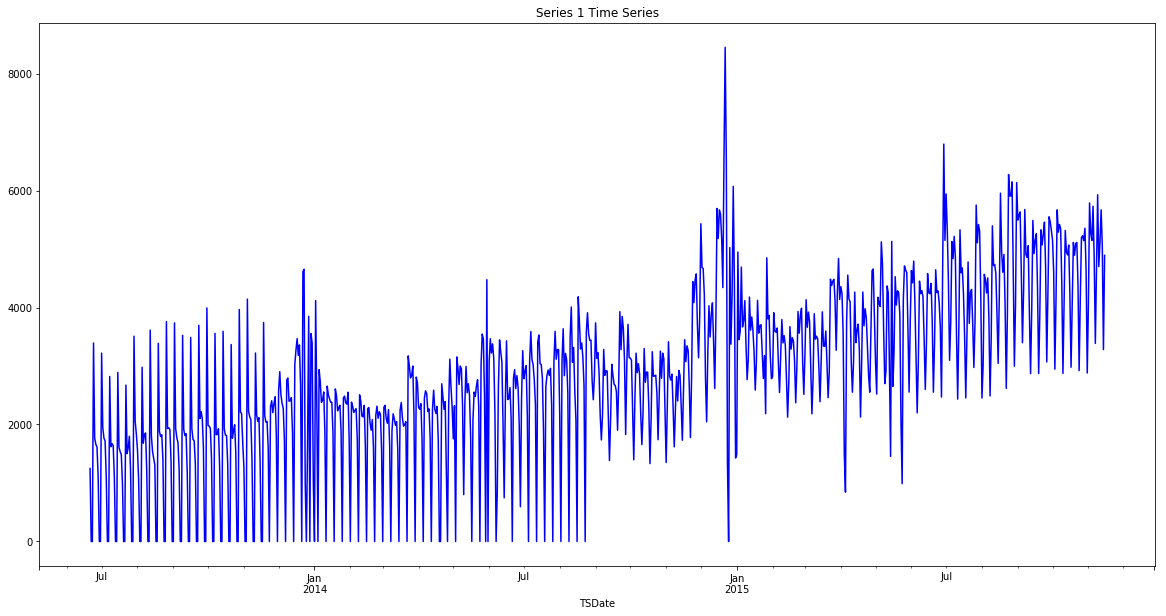

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
train_1 = pd.read_csv('train_1.csv',  index_col='TSDate',date_parser=dateparse, parse_dates=True)

ts = train_1['sales'] 
ts.plot(c='b', title='Series 1 Time Series', figsize=(20,10))
plt.show()

## Forecasting

To forecast the time series, we will use RNN from TensorFlow library. 

First, we need to define a few functions to prepare input data for the neural network.

In [4]:
def batch(X, Y, n_periods):
    X_batches = np.array(X).reshape(-1, n_periods, 1)
    Y_batches = np.array(Y).reshape(-1, n_periods, 1)
    return X_batches, Y_batches

def test_data(series, forecast_horizon, n_periods):
    testXset = TS[:(len(TS)-f_horizon - (len(TS)-f_horizon)%num_periods)]
    testYset = TS[f_horizon:(len(TS)-f_horizon - (len(TS)-f_horizon)%num_periods)+f_horizon]
    testX, testY = batch(testXset, testYset, n_periods)
    return testX, testY

Second, we want to find the best parameters for the NN. We define a few models to test with the different number of training period and hidden layers needed to forecast the next 15 days of sales.

In [5]:
params = [
          {'num_periods': 15, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 15, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 15, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15},
          {'num_periods': 15, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 15, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 15, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 15, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 15, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
          
          {'num_periods': 30, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 30, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 30, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 30, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 30, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 30, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 30, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 30, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
          
          {'num_periods': 60, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 60, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 60, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 60, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 60, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 60, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 60, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 60, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
          
          {'num_periods': 90, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 90, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 90, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 90, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 90, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 90, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 90, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 90, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
          
          {'num_periods': 180, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 180, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 180, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 180, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 180, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 180, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 180, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 180, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
    
          {'num_periods': 365, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 365, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 365, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 365, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 365, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 365, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 365, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 365, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
          
         ]

To find the best set of parameters, we run the algorithm with each set. We then compare MSE values and choose the model with the lowest MSE.

In [6]:
models = []

for i, param in enumerate(params):
    
    print('Model:', i)
    
    num_periods = param['num_periods']      
    inputs = param['inputs']
    hidden = param['hidden']
    output = param['output']
    f_horizon = param['f_horizon']
    
    TS = np.array(ts)

    X_train = TS[:(len(TS)-f_horizon - (len(TS)-f_horizon)%num_periods)]
    Y_train = TS[f_horizon:(len(TS)-f_horizon - (len(TS)-f_horizon)%num_periods)+f_horizon]
    
    X_batch, y_batch = batch(X_train, Y_train, num_periods)
    
    X_test, Y_test = test_data(TS,f_horizon,num_periods)
    
    tf.reset_default_graph()   

    X = tf.placeholder(tf.float32, [None, num_periods, inputs])   
    y = tf.placeholder(tf.float32, [None, num_periods, output])

    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   
    rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)          

    learning_rate = 0.001   

    stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
    stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
    outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])
 
    loss = tf.reduce_mean(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
        
    epochs = 1000
    
    with tf.Session() as sess:
        init.run()
        mse_session = []
        for ep in range(epochs):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if ep % 10 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                mse_session.append(mse)
    
        results = {'params': param, 
                  'mse': min(mse_session)}
        models.append(results)
    
        print('Results:', results)
        print('---------------------------------------------------')

Model: 0
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon': 15}, 'mse': 500969.09}
---------------------------------------------------
Model: 1
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon': 15}, 'mse': 514652.44}
---------------------------------------------------
Model: 2
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon': 15}, 'mse': 431717.34}
---------------------------------------------------
Model: 3
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon': 15}, 'mse': 353896.59}
---------------------------------------------------
Model: 4
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon': 15}, 'mse': 341411.75}
---------------------------------------------------
Model: 5
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon': 15}, 'mse

Results: {'params': {'num_periods': 365, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon': 15}, 'mse': 3647561.0}
---------------------------------------------------
Model: 47
Results: {'params': {'num_periods': 365, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon': 15}, 'mse': 2538074.2}
---------------------------------------------------


In [7]:
mse_list = lambda x: x['mse'] 

best_model = min(models, key=mse_list)

The model with the lowest MSE is:

In [8]:
best_model

{'mse': 48164.734,
 'params': {'f_horizon': 15,
  'hidden': 500,
  'inputs': 1,
  'num_periods': 180,
  'output': 1}}

### Best model training

Now that we know the best set of parameters, we can train the RNN.

In [9]:
num_periods = best_model['params']['num_periods']
inputs = best_model['params']['inputs']
hidden = best_model['params']['hidden']
output = best_model['params']['output']
f_horizon = best_model['params']['f_horizon']

In [10]:
TS = np.array(ts)

X_train = TS[:(len(TS)-f_horizon - (len(TS)-f_horizon)%num_periods)]
Y_train = TS[f_horizon:(len(TS)-f_horizon - (len(TS)-f_horizon)%num_periods)+f_horizon]
    
X_batch, y_batch = batch(X_train, Y_train, num_periods)
    
X_test, Y_test = test_data(TS,f_horizon,num_periods)
    
tf.reset_default_graph()   

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)          

learning_rate = 0.001   

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])
 
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
        
epochs = 1000
    
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    saver.save(sess, "./serie1_model")

0 	MSE: 6.27835e+06
100 	MSE: 475074.0
200 	MSE: 394940.0
300 	MSE: 283073.0
400 	MSE: 394800.0
500 	MSE: 297752.0
600 	MSE: 205382.0
700 	MSE: 131712.0
800 	MSE: 132422.0
900 	MSE: 194423.0


The following graph illustrates the actual values and the forecasted ones. As can be seen, the RNN could capture not only the general tren but also sudden increases and decrease in sales.

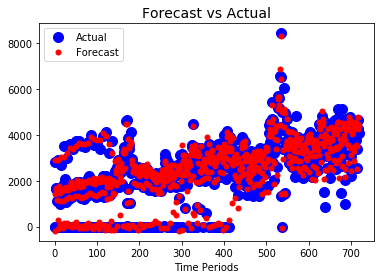

In [11]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

### Best model forecast 

At last, we are going to predict the sales from 2015/11/16 to 2015/11/30 (e.g. 15 periods into the future). Hence, the last 15 data points of *y_pred* below are the predictions

In [12]:
with tf.Session() as sess:
    saver.restore(sess, "./serie1_model")
    TS_input = TS[-num_periods:]
    X_new = np.array(TS_input).reshape(-1, num_periods, 1)
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred.reshape(num_periods)[-15:])

INFO:tensorflow:Restoring parameters from ./serie1_model
[ 5252.02050781  5112.41748047  4993.25292969  5150.140625    4909.3671875
  2857.91455078  4304.765625    7304.87988281  6948.15527344  7273.71484375
  7249.37011719  6889.00634766  4503.65429688  6684.25585938  9616.515625  ]


# Series 2

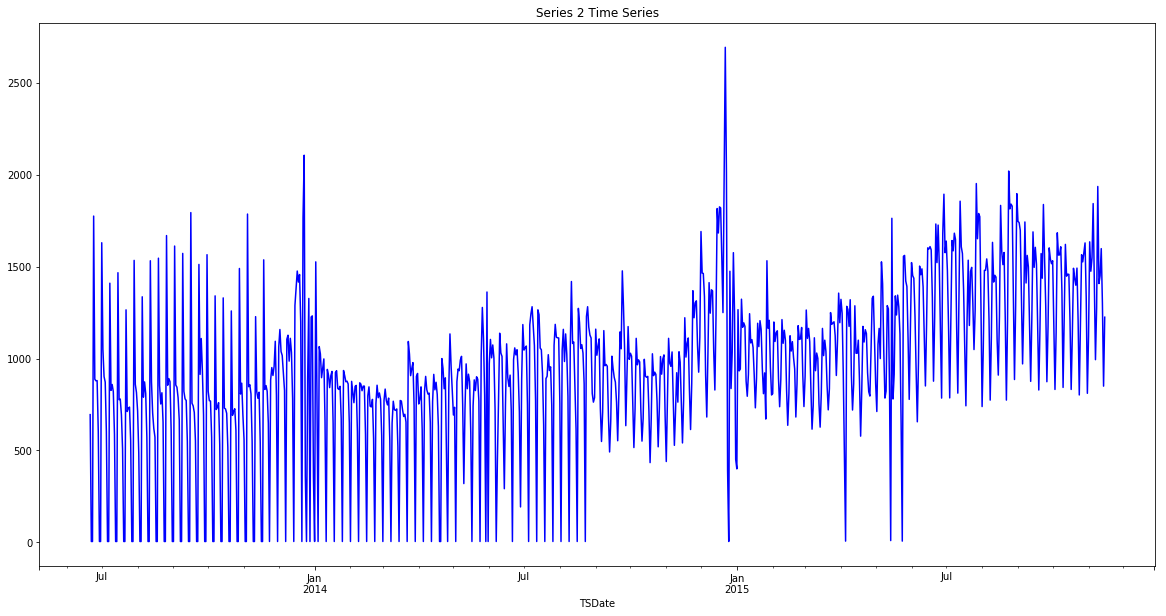

In [13]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
train_2 = pd.read_csv('train_2.csv',  index_col='TSDate',date_parser=dateparse, parse_dates=True)

ts2 = train_2['sales'] 
ts2.plot(c='b', title='Series 2 Time Series', figsize=(20,10))
plt.show()

In [14]:
params = [
          {'num_periods': 15, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 15, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 15, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15},
          {'num_periods': 15, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 15, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 15, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 15, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 15, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
          
          {'num_periods': 30, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 30, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 30, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 30, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 30, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 30, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 30, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 30, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
          
          {'num_periods': 60, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 60, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 60, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 60, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 60, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 60, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 60, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 60, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
          
          {'num_periods': 90, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 90, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 90, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 90, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 90, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 90, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 90, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 90, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
          
          {'num_periods': 180, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 180, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 180, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 180, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 180, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 180, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 180, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 180, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
    
          {'num_periods': 365, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 365, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 365, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon':15}, 
          {'num_periods': 365, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon':15},
          {'num_periods': 365, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon':15},
          {'num_periods': 365, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon':15},
          {'num_periods': 365, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon':15},
          {'num_periods': 365, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon':15},
          
         ]

In [16]:
models = []

for i, param in enumerate(params):
    
    print('Model:', i)
    
    num_periods = param['num_periods']      
    inputs = param['inputs']
    hidden = param['hidden']
    output = param['output']
    f_horizon = param['f_horizon']
    
    TS = np.array(ts2)

    X_train = TS[:(len(TS)-f_horizon - (len(TS)-f_horizon)%num_periods)]
    Y_train = TS[f_horizon:(len(TS)-f_horizon - (len(TS)-f_horizon)%num_periods)+f_horizon]
    
    X_batch, y_batch = batch(X_train, Y_train, num_periods)
    
    X_test, Y_test = test_data(TS,f_horizon,num_periods)
    
    tf.reset_default_graph()   

    X = tf.placeholder(tf.float32, [None, num_periods, inputs])   
    y = tf.placeholder(tf.float32, [None, num_periods, output])

    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   
    rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)          

    learning_rate = 0.001   

    stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
    stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
    outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])
 
    loss = tf.reduce_mean(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
        
    epochs = 1000
    
    with tf.Session() as sess:
        init.run()
        mse_session = []
        for ep in range(epochs):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if ep % 10 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                mse_session.append(mse)
    
        results = {'params': param, 
                  'mse': min(mse_session)}
        models.append(results)
    
        print('Results:', results)
        print('---------------------------------------------------')

Model: 0
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 50, 'output': 1, 'f_horizon': 15}, 'mse': 62708.492}
---------------------------------------------------
Model: 1
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 75, 'output': 1, 'f_horizon': 15}, 'mse': 54790.035}
---------------------------------------------------
Model: 2
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 100, 'output': 1, 'f_horizon': 15}, 'mse': 49919.543}
---------------------------------------------------
Model: 3
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 150, 'output': 1, 'f_horizon': 15}, 'mse': 51799.109}
---------------------------------------------------
Model: 4
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 250, 'output': 1, 'f_horizon': 15}, 'mse': 43361.719}
---------------------------------------------------
Model: 5
Results: {'params': {'num_periods': 15, 'inputs': 1, 'hidden': 500, 'output': 1, 'f_horizon': 15}, 'mse

Results: {'params': {'num_periods': 365, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon': 15}, 'mse': 25873.441}
---------------------------------------------------
Model: 47
Results: {'params': {'num_periods': 365, 'inputs': 1, 'hidden': 1000, 'output': 1, 'f_horizon': 15}, 'mse': 297807.56}
---------------------------------------------------


In [17]:
mse_list = lambda x: x['mse'] 

best_model = min(models, key=mse_list)

print(best_model)

{'params': {'num_periods': 90, 'inputs': 1, 'hidden': 750, 'output': 1, 'f_horizon': 15}, 'mse': 3956.1667}


In [18]:
num_periods = best_model['params']['num_periods']
inputs = best_model['params']['inputs']
hidden = best_model['params']['hidden']
output = best_model['params']['output']
f_horizon = best_model['params']['f_horizon']

In [19]:
TS = np.array(ts2)

X_train = TS[:(len(TS)-f_horizon - (len(TS)-f_horizon)%num_periods)]
Y_train = TS[f_horizon:(len(TS)-f_horizon - (len(TS)-f_horizon)%num_periods)+f_horizon]
    
X_batch, y_batch = batch(X_train, Y_train, num_periods)
    
X_test, Y_test = test_data(TS,f_horizon,num_periods)
    
tf.reset_default_graph()   

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)          

learning_rate = 0.001   

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])
 
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
        
epochs = 1000
    
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    saver.save(sess, "./serie2_model")

0 	MSE: 550189.0
100 	MSE: 61802.5
200 	MSE: 43995.2
300 	MSE: 36708.3
400 	MSE: 30438.3
500 	MSE: 40986.1
600 	MSE: 30958.6
700 	MSE: 54825.2
800 	MSE: 27890.4
900 	MSE: 14243.0


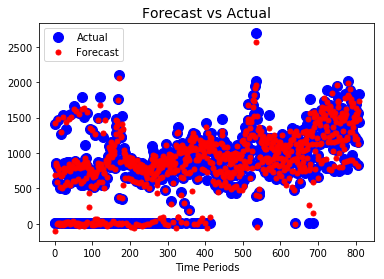

In [20]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

In [22]:
with tf.Session() as sess:
    saver.restore(sess, "./serie2_model")
    
    TS_input = TS[-num_periods:]

    X_new = np.array(TS_input).reshape(-1, num_periods, 1)
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred.reshape(num_periods)[-15:])

INFO:tensorflow:Restoring parameters from ./serie2_model
[ 1840.02648926  1684.5949707   1970.5769043   2015.05981445  1683.01525879
  1094.55578613  1524.78442383  2355.58374023  2355.86254883  2456.48999023
  2319.86450195  1613.11047363  1088.00463867  1802.62683105  2373.20556641]
